In [1]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
import mystyle

sns.set_palette('colorblind')
sns.set_context('poster')

In [2]:
ati = pd.read_csv('../../data/atium.csv',index_col=0)

#Exclude those stars with a Rhat > 1.01 flag and no results otherwise
ati = ati[np.isfinite(ati.nus.values)]
ati = ati.loc[ati.flag != 'rhat_1' ]
# ati = ati.loc[ati.flag != 'rhat_01' ]
print(f'We have {len(ati)} stars with Rhats below 1.01')

We have 82 stars with Rhats below 1.01


### Read in the JvS+19 models

In [3]:
standard = pd.read_csv('../../data/jvs_models/standard_model.csv', index_col=None)
standard.rename(columns={'# Teff(K)':'Teff', ' Prot(days)':'P',
                         ' Age(Gyr)':'Age',' Mass(Msun)':'M', ' Ro ':'Ro'}, inplace=True)
standard.head(1)

,Teff,P,Age,M,Ro
0,3425.943077,3.132252,2.343081,0.39749,0.028923


In [4]:
rocrit = pd.read_csv('../../data/jvs_models/rocrit_model.csv', index_col=None)
rocrit.rename(columns={'#Teff(K)':'Teff', ' Prot(days)':'P',
                         ' Age(Gyr)':'Age',' Mass(Msun)':'M', ' Ro ':'Ro'}, inplace=True)
rocrit.head(1)

,Teff,P,Age,M,Ro
0,3425.943077,3.132252,2.343081,0.39749,0.028923


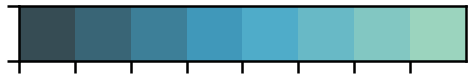

In [5]:
from matplotlib.colors import ListedColormap
snsmap = sns.color_palette('GnBu_d',8)
cmap = ListedColormap(snsmap.as_hex())
sns.palplot(snsmap)

## 1.) Seismic Sample overplotted on "standard" Teff vs Period

This is a TRILEGAL model corrected for the *Kepler* and McQuillan et al. 2014 selection biases. No new (e.g. proposed in JvS+19) detection bias or stellar physics are proposed here.

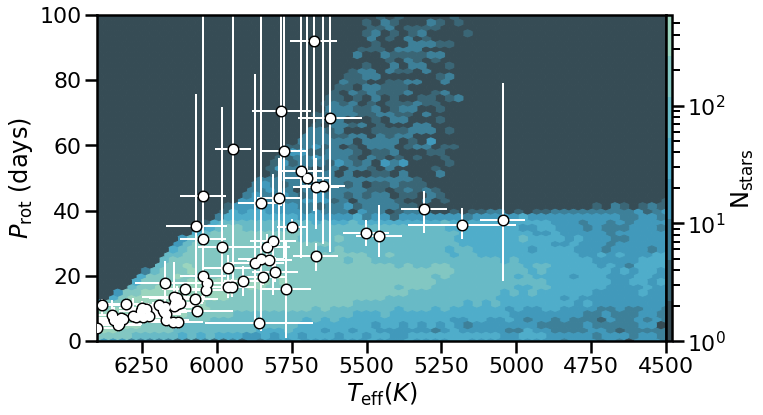

In [6]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
c = ax.hexbin(standard.Teff, standard.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(ati.Teff, ati.P, c='w', s=50,zorder=3)
ax.scatter(ati.Teff, ati.P, c='k', s=100,zorder=2)
ax.errorbar(ati.Teff, ati.P, c='w', lw=2, xerr=ati.eTeff, yerr=[ati.l_P, ati.u_P], fmt='|', zorder=1)
ax.set_ylim(0, 100)
ax.set_xlim(6400, 4500)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

## 2.) The same, but nothing with Ro > 2. Colour coded by whether they have spot modulation or not

$R_{\rm o} = \large\frac{P_{\rm rot}}{\tau_{\rm cv}}$, where

$\log(\tau_{\rm cv}) = 1.16 - 1.49\log(M / M_{\odot}) - 0.54\log(M / M_{\odot})^2$

In [7]:
Ro = ati.P / 10**(1.16 - 1.49*np.log10(ati.modmass) - 0.54*np.log10(ati.modmass)**2)

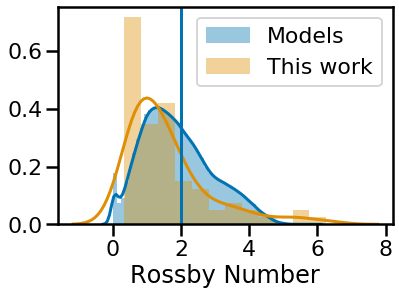

In [8]:
sns.distplot(standard.Ro, label='Models')
sns.distplot(Ro, label='This work')
plt.legend()
plt.axvline(2.)
plt.xlabel('Rossby Number')
s = Ro < 2
sf = standard.Ro.values < 2

This is a TRILEGAL model, corrected for the *Kepler* selection function and MMA14 biases, but only showing stars with a Rossby Number below 2. This checks the proposal that above a certain Rossby number (~2) rotational modulation cannot be measured.

Asteroseismic measurements do not rely on starspots. If asteroseismic measurements align with this model, it implies that whatever is stopping the spot modulation measurements also affects the internal rotation.

In [9]:
lit = pd.read_csv('../../data/lit_spot_rots.csv', index_col=0)
ati = ati.merge(lit, on='KIC', how='left')
ati.index = s.index

I have checked **Nielsen et al. 2013, Santos et al. 2019, McQuillan et al. 2014,and van Saders et al. 2016** for surface rotation.

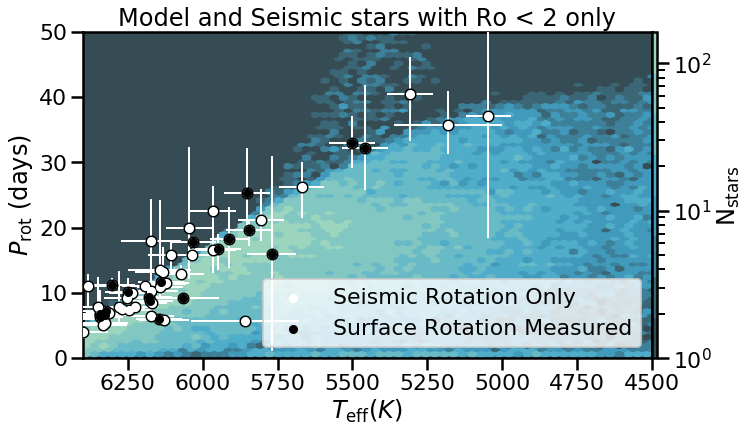

In [10]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
c = ax.hexbin(standard.Teff[sf], standard.P[sf], cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(ati.Teff[s], ati.P[s], c='w', s=50,zorder=5, label='Seismic Rotation Only')
ax.scatter(ati.Teff[s], ati.P[s], c='k', s=100,zorder=4)
ax.errorbar(ati.Teff[s], ati.P[s], c='w', lw=2, 
            xerr=ati.eTeff[s], yerr=[ati.l_P[s], ati.u_P[s]], fmt='|', zorder=3)

s2 = ati.Flag[s] == 1.0
ax.scatter(ati.Teff[s][s2], ati.P[s][s2], c='k', s=50,zorder=5, label='Surface Rotation Measured')


# ax.scatter(ati.Teff[~s], ati.P[~s], c='k', s=50,zorder=2, alpha=.5, label='~Ro > 2')
# ax.scatter(ati.Teff[~s], ati.P[~s], c='w', s=100,zorder=2, alpha=.5)
# ax.errorbar(ati.Teff[~s], ati.P[~s], c='k', lw=2, 
#             xerr=ati.eTeff[~s], yerr=[ati.l_P[~s], ati.u_P[~s]], fmt='|', zorder=1, alpha=.5)

ax.set_ylim(0, 50)
ax.set_xlim(6400, 4500)
ax.set_title('Model and Seismic stars with Ro < 2 only')
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.legend(loc='lower right')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

## 3.) Same, but against all stars in the RoCrit model

This is a TRILEGAL model, corrected for the *Kepler* selection function and MMA14 biases, but only showing stars with a Rossby Number below 2. The TRILEGAL model was evolved under the assumption that magnetic braking is weakened above a Rossby Number of 2.18 (van Saders+2016). This plot checks the proposal that above a certain Rossby number (~2) rotational modulation cannot be measured, **and** that rotational braking is slowed above a critical Rossby Number of 2.18.

If asteroseismic measurements agree with this plot, it implies that there is indeed a weakening of magnetic braking apparent in the internal rotation periods.

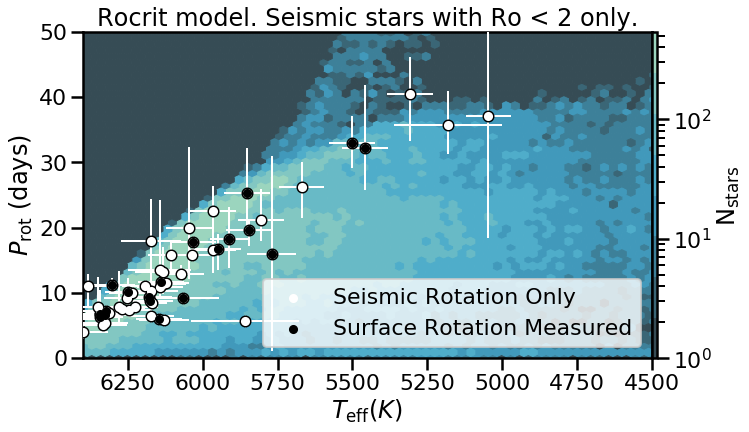

In [12]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(ati.Teff[s], ati.P[s], c='w', s=50,zorder=5, label='Seismic Rotation Only')
ax.scatter(ati.Teff[s], ati.P[s], c='k', s=100,zorder=4)
ax.errorbar(ati.Teff[s], ati.P[s], c='w', lw=2, 
            xerr=ati.eTeff[s], yerr=[ati.l_P[s], ati.u_P[s]], fmt='|', zorder=3)

s2 = ati.Flag[s] == 1.0
ax.scatter(ati.Teff[s][s2], ati.P[s][s2], c='k', s=50,zorder=5, label='Surface Rotation Measured')


ax.set_ylim(0, 50)
ax.set_xlim(6400, 4500)
ax.set_title('Rocrit model. Seismic stars with Ro < 2 only.')
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.legend(loc='lower right')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

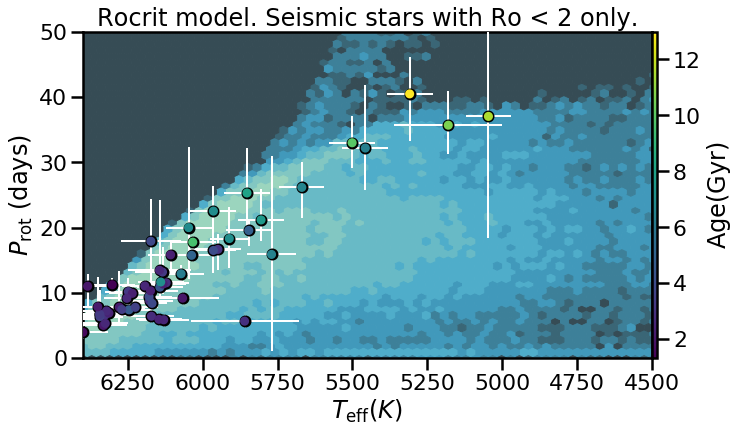

In [13]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
c= ax.scatter(ati.Teff[s], ati.P[s], c=ati.age[s], s=50,zorder=5)
ax.scatter(ati.Teff[s], ati.P[s], c='k', s=100,zorder=4)
ax.errorbar(ati.Teff[s], ati.P[s], c='w', lw=2, 
            xerr=ati.eTeff[s], yerr=[ati.l_P[s], ati.u_P[s]], fmt='|', zorder=3)

ax.set_ylim(0, 50)
ax.set_xlim(6400, 4500)
ax.set_title('Rocrit model. Seismic stars with Ro < 2 only.')
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
fig.colorbar(c,label=r'$\rm{Age (Gyr)}$', pad=0,aspect=60)

## 4) Same, but for all Rossby Numbers

This is a TRILEGAL model, corrected for the *Kepler* selection function and MMA14 biases. The TRILEGAL model was evolved under the assumption that magnetic braking is weakened above a Rossby Number of 2.18 (van Saders+2016). This plot checks the proposal that rotational braking is slowed above a critical Rossby Number of 2.18.

If asteroseismic measurements agree with this plot, it implies that there is indeed a weakening of magnetic braking apparent in the internal rotation periods.

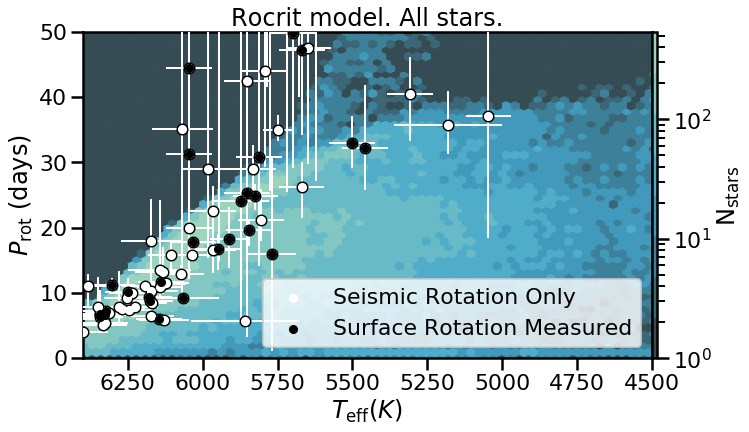

In [14]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(ati.Teff, ati.P, c='w', s=50,zorder=5, label='Seismic Rotation Only')
ax.scatter(ati.Teff, ati.P, c='k', s=100,zorder=4)
ax.errorbar(ati.Teff, ati.P, c='w', lw=2, 
            xerr=ati.eTeff, yerr=[ati.l_P, ati.u_P], fmt='|', zorder=3)

s2 = ati.Flag == 1.0
ax.scatter(ati.Teff[s2], ati.P[s2], c='k', s=50,zorder=5, label='Surface Rotation Measured')

ax.set_ylim(0, 50)
ax.set_xlim(6400, 4500)
ax.set_title('Rocrit model. All stars.')
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.legend(loc='lower right')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)

The high period stars are not explained by any model we address here. However the uncertainties on period on these stars is very large. Further assessment is required.